In [3]:
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import pandas as pd

In [5]:
data = np.load('/kaggle/input/pos-r100-clean/clean_pos_data.npy')
data.shape

(98664, 280)

In [6]:
test_ind = [5,93906,20527]
new_data = np.delete(data,test_ind,axis=0)
new_data.shape

(98661, 280)

In [7]:
train_data = new_data
new_spec = np.zeros_like(train_data[:,:271])
for i in range(len(train_data)):
    mean_sp = np.mean(train_data[i,:269])
    std_sp = np.std(train_data[i,:269])
    new_spec[i,:269] = (train_data[i,:269] - mean_sp) / std_sp
    new_spec[i,269] = mean_sp
    new_spec[i,270] = std_sp
new_spec.shape

(98661, 271)

In [8]:
X = new_spec
Y = new_data[:,272:]
Y = np.delete(Y,1,1)
X.shape, Y.shape

((98661, 271), (98661, 7))

In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
Y = scaler.fit_transform(Y)

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.15, random_state = 42)


In [11]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((83861, 271), (14800, 271), (83861, 7), (14800, 7))

In [12]:
import tensorflow as tf

2024-08-09 08:32:09.340584: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 08:32:09.340693: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 08:32:09.457401: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [13]:
# Define the CNN model
def create_model(input_shape):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(tf.keras.layers.MaxPooling1D())
    model.add(tf.keras.layers.Dropout(0.05))
    model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(tf.keras.layers.MaxPooling1D())
#     model.add(tf.keras.layers.Conv1D(128, 3, activation='relu'))
#     model.add(tf.keras.layers.MaxPooling1D())
#     model.add(tf.keras.layers.Conv1D(64, 3, activation='relu'))
    model.add(tf.keras.layers.Flatten())
    
    model.add(tf.keras.layers.Dense(350, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.10))
    model.add(tf.keras.layers.Dense(50, activation='relu'))
#     model.add(tf.keras.layers.Dropout(0.1))
#     model.add(tf.keras.layers.Dense(32, activation='relu'))
    model.add(tf.keras.layers.Dense(y_train.shape[1], activation='linear'))
    return model

# Instantiate and compile the model
input_shape = (X_train.shape[1],1)
model = create_model(input_shape)
opt =  tf.keras.optimizers.Adam(1e-3)
model.compile(optimizer=opt, loss='mse', metrics=['mae','r2_score'])
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 269, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 134, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 134, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 132, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 66, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8448)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 350)            │     2,957,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 350)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │        17,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           357 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,000,017 (11.44 MB)

 Trainable params: 3,000,017 (11.44 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model.evaluate(X_test,y_test)

 97/463 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3340 - mae: 0.5016 - r2_score: -3.0051

I0000 00:00:1723192347.856459     125 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


463/463 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.3352 - mae: 0.5027 - r2_score: -3.0083


[0.33569395542144775, 0.5031013488769531, -3.008638858795166]

In [17]:
tr_cnn = tf.keras.models.load_model('/kaggle/input/tf-cnn/cnn_dropout_model.keras')
tr_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 269, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 134, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 134, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 132, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 66, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8448)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 350)            │     2,957,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 350)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │        17,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           357 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,000,053 (34.33 MB)

 Trainable params: 3,000,017 (11.44 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,000,036 (22.89 MB)

In [19]:
model = tr_cnn
model.evaluate(X_test,y_test)

463/463 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0041 - mae: 0.0440 - r2_score: 0.9510


[0.004087872803211212, 0.04368539899587631, 0.9511308670043945]

## Testing on 3 Planets

In [21]:
file_data = np.load('/kaggle/input/pos-r100-clean/clean_pos_data.npy')
file_data.shape

(98664, 280)

In [22]:
mean = np.mean(file_data[5,:269])
std = np.std(file_data[5,:269])
planetA_spec = (file_data[5,:269] - mean) / std
planetA_spec = np.concatenate([planetA_spec,np.array([mean]),np.array([std])])
planetA_params = file_data[5,269:]
planetA_params = np.delete(planetA_params,4)
planetA_spec.shape, planetA_params.shape

((271,), (10,))

In [23]:
mean = np.mean(file_data[93906,:269])
std = np.std(file_data[93906,:269])
planetB_spec = (file_data[93906,:269] - mean) / std
planetB_spec = np.concatenate([planetB_spec,np.array([mean]),np.array([std])])
planetB_params = file_data[93906,269:]
planetB_params = np.delete(planetB_params,4)
planetB_spec.shape, planetB_params.shape

((271,), (10,))

In [24]:
mean = np.mean(file_data[20527,:269])
std = np.std(file_data[20527,:269])
planetC_spec = (file_data[20527,:269] - mean) / std
planetC_spec = np.concatenate([planetC_spec,np.array([mean]),np.array([std])])
planetC_params = file_data[20527,269:]
planetC_params = np.delete(planetC_params,4)
planetC_spec.shape, planetC_params.shape

((271,), (10,))

In [25]:
test_planets = np.array([planetA_spec,planetB_spec,planetC_spec])
test_planets = test_planets.reshape(3,271)
test_planets.shape

(3, 271)

In [26]:
predictions = model.predict(test_planets)
predictions = scaler.inverse_transform(predictions)
predictions.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step


W0000 00:00:1723192820.970271     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


(3, 7)

### Planet A

In [27]:
planetA_pred = predictions[0]
print("Predicted values:",planetA_pred)
print("Actual values:",planetA_params[3:])

Predicted values: [ 2.2921523e+03 -5.8455002e-01 -5.7802324e+00 -6.1363530e+00
 -3.1029358e+00 -3.9507985e+00 -5.3056207e+00]
Actual values: [ 2.25464503e+03 -4.32719523e-01 -5.92972315e+00 -6.08127349e+00
 -2.73321161e+00 -3.87322226e+00 -5.41191367e+00]


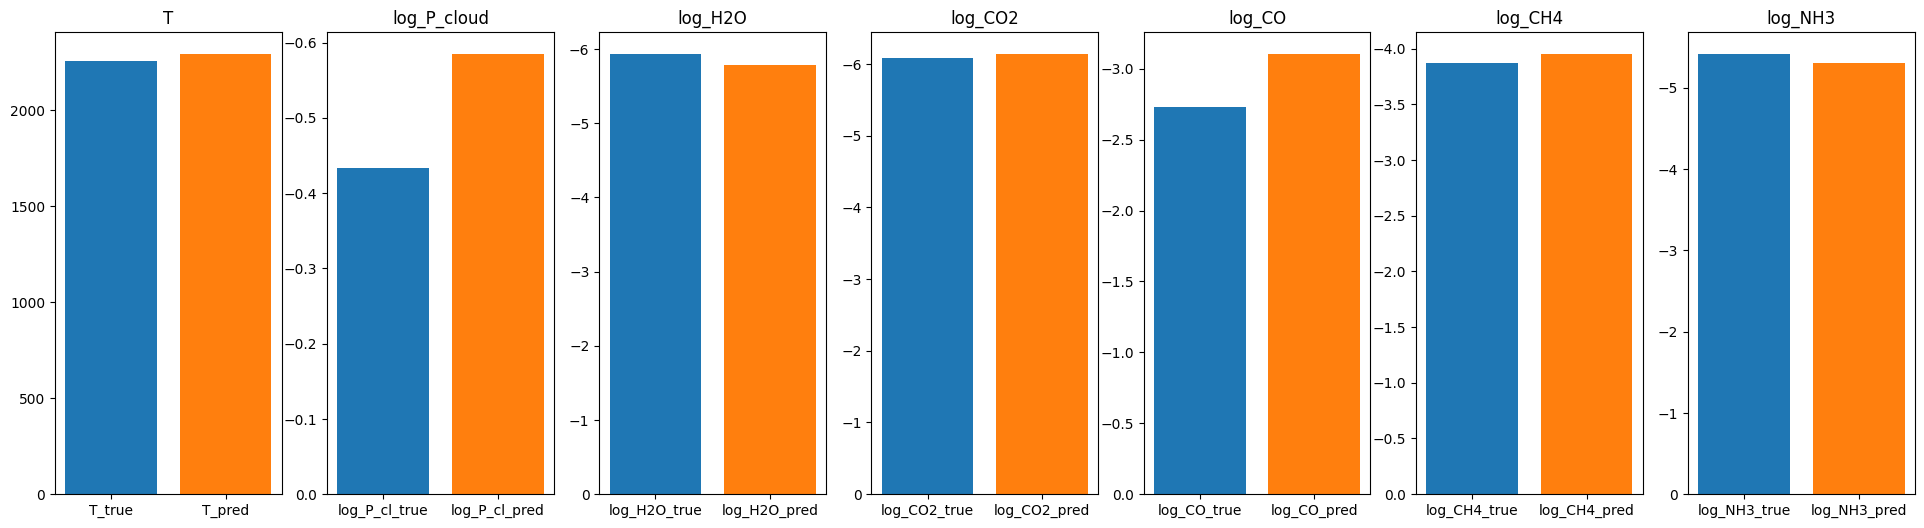

In [29]:
keys = ['T', 'log_P_cloud', 'log_H2O', 'log_CO2', 'log_CO', 'log_CH4', 'log_NH3']
labels1 = ['T_true', 'log_P_cl_true', 'log_H2O_true', 'log_CO2_true', 'log_CO_true', 'log_CH4_true', 'log_NH3_true']
labels2 = ['T_pred', 'log_P_cl_pred', 'log_H2O_pred', 'log_CO2_pred', 'log_CO_pred', 'log_CH4_pred', 'log_NH3_pred']
fig, axs = plt.subplots(1, 7, figsize=(24,6))

for i in range(7):
    if i > 0:
        axs[i].bar(labels1[i], planetA_params[3+i])
        axs[i].bar(labels2[i], planetA_pred[i])
        
        axs[i].set_title(keys[i])
        axs[i].invert_yaxis()
    else:
        axs[i].bar(labels1[i], planetA_params[3+i])
        axs[i].bar(labels2[i], planetA_pred[i])
        
        axs[i].set_title(keys[i])

In [45]:
pred_err = []
for i in range(1000):
    pred_err.append(model(test_planets[0:1,:],training = True).numpy().squeeze())
prediction_dropout_ensemble = np.array(pred_err)

prediction_dropout_ensemble = scaler.inverse_transform(prediction_dropout_ensemble)
pred_med = np.median(prediction_dropout_ensemble,axis=0)

low_sigma = []
high_sigma = []
for i in range(7):
    high_sigma.append(np.percentile(prediction_dropout_ensemble[:,i],84.1))
    low_sigma.append(np.percentile(prediction_dropout_ensemble[:,i],15.9))

low_sigma = np.array(low_sigma)
high_sigma = np.array(high_sigma)

In [46]:
pred_med

array([ 2.2895957e+03, -5.1856315e-01, -5.8497391e+00, -6.0509844e+00,
       -2.9578357e+00, -3.8079944e+00, -5.3873682e+00], dtype=float32)

In [47]:
low_sigma - pred_med, high_sigma - pred_med

(array([-8.06508208e+01, -1.58882778e-01, -1.09997163e-01, -8.99149003e-02,
        -1.53301905e-01, -6.17230980e-02, -9.91418304e-02]),
 array([7.59390764e+01, 8.16798407e-02, 1.68477139e-01, 7.01671991e-02,
        9.52364805e-02, 5.73491237e-02, 1.51999842e-01]))

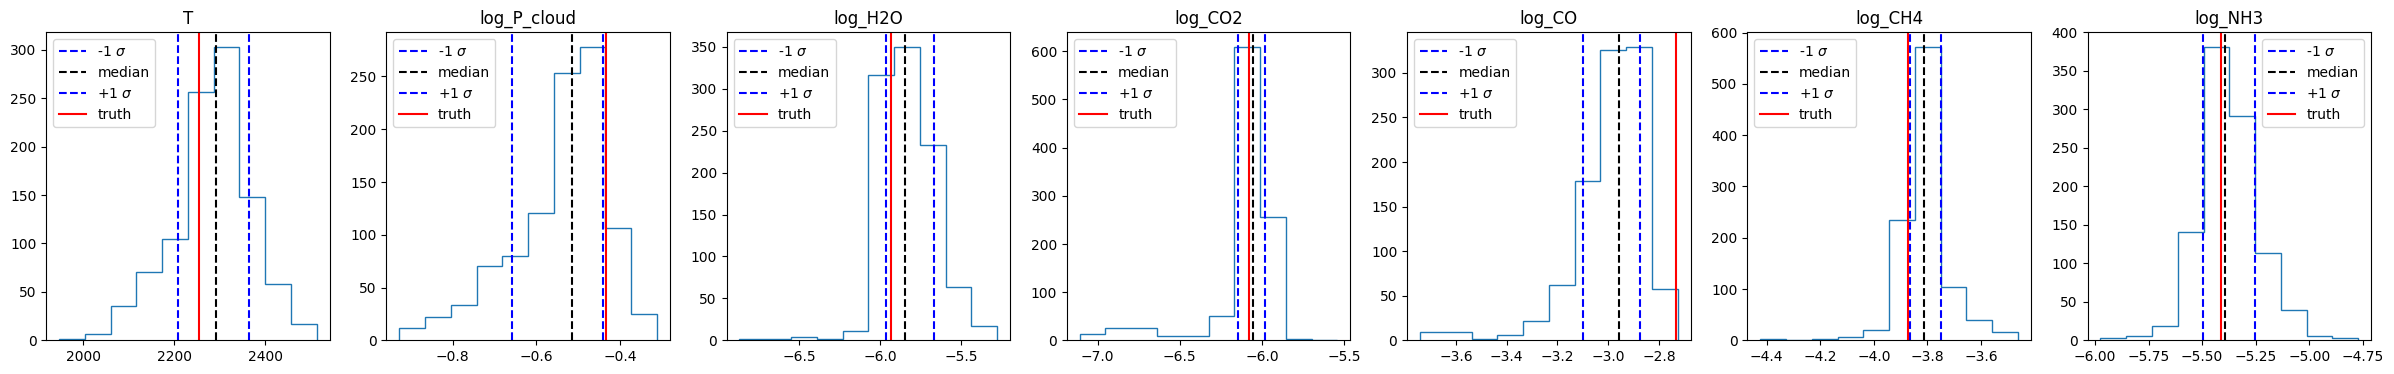

In [32]:
keys = ['T', 'log_P_cloud', 'log_H2O', 'log_CO2', 'log_CO', 'log_CH4', 'log_NH3']
fig, axs = plt.subplots(1, 7, figsize=(30,4))

for i in range(7):
#     if i < 4:
        axs[i].hist(prediction_dropout_ensemble[:,i],histtype='step',bins=10)
        axs[i].axvline(x=low_sigma[i],color='blue',ls='--',label='-1 $\sigma$')
        axs[i].axvline(x=pred_med[i],color='black',ls='--',label='median')
        axs[i].axvline(x=high_sigma[i],color='blue',ls='--',label='+1 $\sigma$')
        axs[i].axvline(x=planetA_params[3+i],color='red',label='truth')
        axs[i].set_title(keys[i])
        axs[i].legend()

### Planet B

In [33]:
planetB_pred = predictions[1]
print("Predicted values:",planetB_pred)
print("Actual values:",planetB_params[3:])

Predicted values: [1359.1577      -3.456871    -1.9769974   -6.814479    -5.271384
   -7.66441     -4.871433 ]
Actual values: [1494.42281919   -3.87293773   -2.00001683   -6.69599784   -5.56826031
   -6.57170199   -4.38080597]


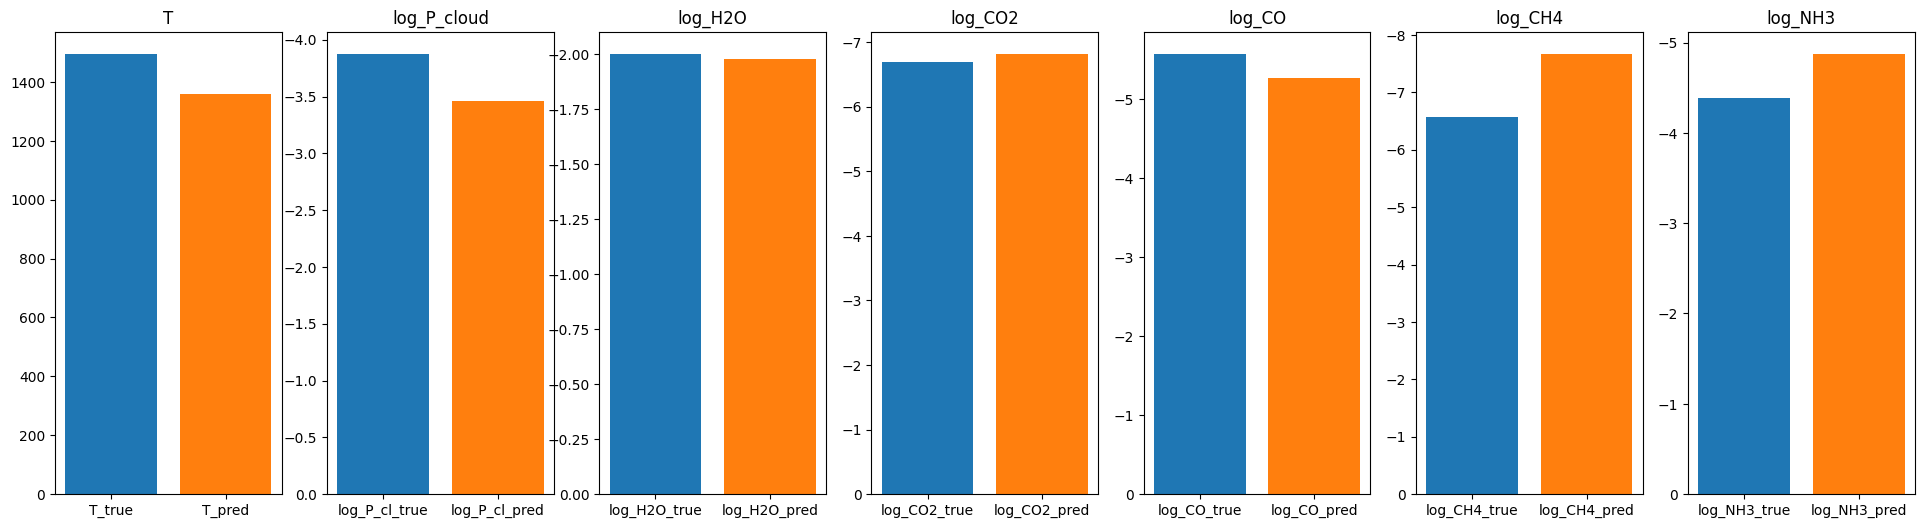

In [34]:
labels1 = ['T_true', 'log_P_cl_true', 'log_H2O_true', 'log_CO2_true', 'log_CO_true', 'log_CH4_true', 'log_NH3_true']
labels2 = ['T_pred', 'log_P_cl_pred', 'log_H2O_pred', 'log_CO2_pred', 'log_CO_pred', 'log_CH4_pred', 'log_NH3_pred']
fig, axs = plt.subplots(1, 7, figsize=(24,6))

for i in range(7):
    if i > 0:
        axs[i].bar(labels1[i], planetB_params[3+i])
        axs[i].bar(labels2[i], planetB_pred[i])
        
        axs[i].set_title(keys[i])
        axs[i].invert_yaxis()
    else:
        axs[i].bar(labels1[i], planetB_params[3+i])
        axs[i].bar(labels2[i], planetB_pred[i])
        
        axs[i].set_title(keys[i])

In [35]:
pred_err = []
for i in range(1000):
    pred_err.append(model(test_planets[1:2,:],training = True).numpy().squeeze())
prediction_dropout_ensemble = np.array(pred_err)

prediction_dropout_ensemble = scaler.inverse_transform(prediction_dropout_ensemble)
pred_med = np.median(prediction_dropout_ensemble,axis=0)

low_sigma = []
high_sigma = []
for i in range(7):
    high_sigma.append(np.percentile(prediction_dropout_ensemble[:,i],84.1))
    low_sigma.append(np.percentile(prediction_dropout_ensemble[:,i],15.9))

low_sigma = np.array(low_sigma)
high_sigma = np.array(high_sigma)

In [36]:
pred_med

array([1349.1067   ,   -3.530147 ,   -1.9579268,   -6.8421516,
         -5.292597 ,   -7.6467085,   -4.8937874], dtype=float32)

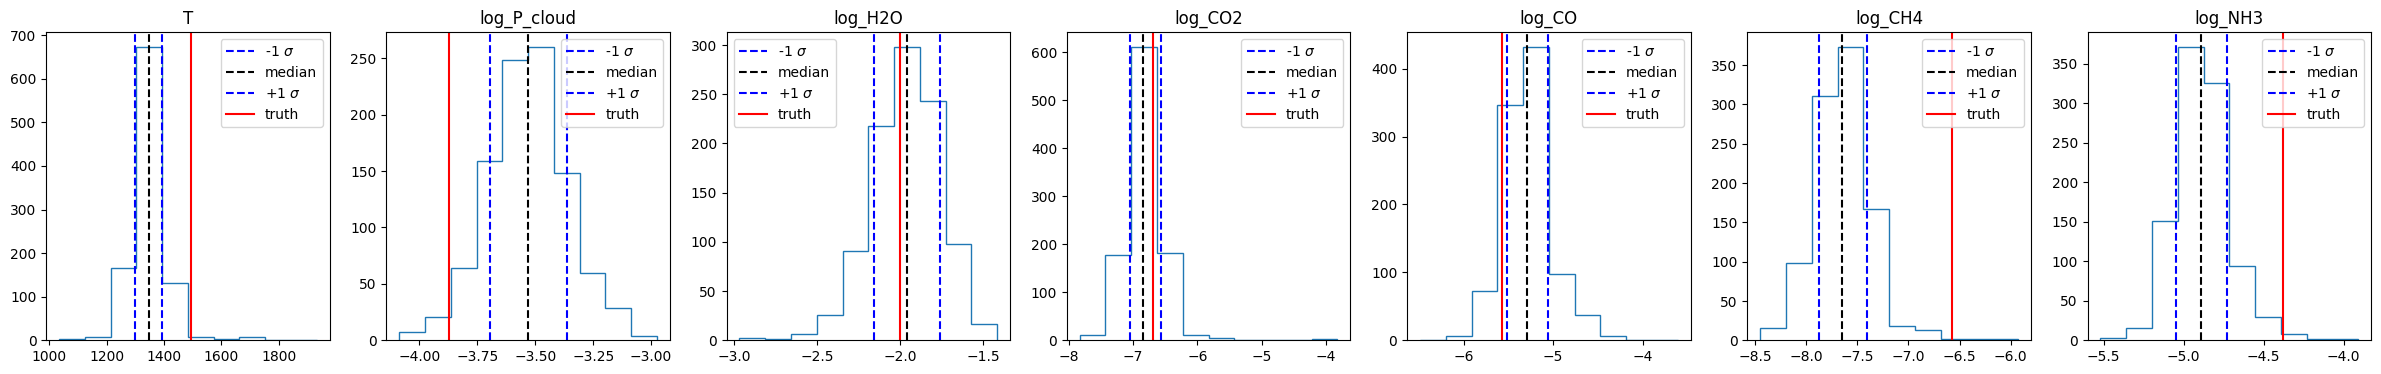

In [37]:
keys = ['T', 'log_P_cloud', 'log_H2O', 'log_CO2', 'log_CO', 'log_CH4', 'log_NH3']
fig, axs = plt.subplots(1, 7, figsize=(30,4))

for i in range(7):
#     if i < 4:
        axs[i].hist(prediction_dropout_ensemble[:,i],histtype='step',bins=10)
        axs[i].axvline(x=low_sigma[i],color='blue',ls='--',label='-1 $\sigma$')
        axs[i].axvline(x=pred_med[i],color='black',ls='--',label='median')
        axs[i].axvline(x=high_sigma[i],color='blue',ls='--',label='+1 $\sigma$')
        axs[i].axvline(x=planetB_params[3+i],color='red',label='truth')
        axs[i].set_title(keys[i])
        axs[i].legend()

### Planet C

In [38]:
planetC_pred = predictions[2]
print("Predicted values:",planetC_pred)
print("Actual values:",planetC_params[3:])

Predicted values: [ 9.0263818e+02  4.9171904e-01 -7.4563842e+00 -5.2225599e+00
 -4.8041234e+00 -3.1436687e+00 -3.0212412e+00]
Actual values: [ 1.01071679e+03  4.78646000e-01 -6.14987707e+00 -5.47199553e+00
 -4.82762328e+00 -2.92644183e+00 -3.01204914e+00]


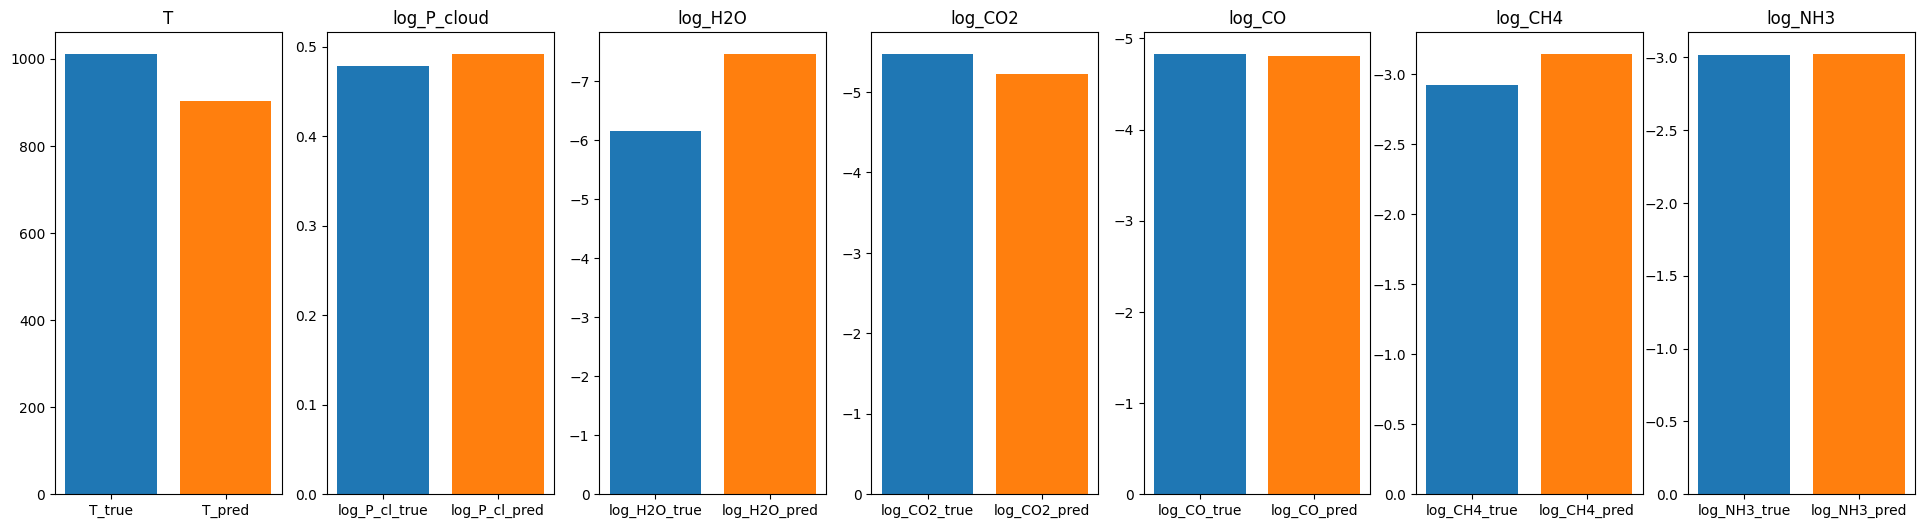

In [39]:
labels1 = ['T_true', 'log_P_cl_true', 'log_H2O_true', 'log_CO2_true', 'log_CO_true', 'log_CH4_true', 'log_NH3_true']
labels2 = ['T_pred', 'log_P_cl_pred', 'log_H2O_pred', 'log_CO2_pred', 'log_CO_pred', 'log_CH4_pred', 'log_NH3_pred']
fig, axs = plt.subplots(1, 7, figsize=(24,6))

for i in range(7):
    if i > 1:
        axs[i].bar(labels1[i], planetC_params[3+i])
        axs[i].bar(labels2[i], planetC_pred[i])
        
        axs[i].set_title(keys[i])
        axs[i].invert_yaxis()
    else:
        axs[i].bar(labels1[i], planetC_params[3+i])
        axs[i].bar(labels2[i], planetC_pred[i])
        
        axs[i].set_title(keys[i])

In [40]:
pred_err = []
for i in range(1000):
    pred_err.append(model(test_planets[2:3,:],training = True).numpy().squeeze())
prediction_dropout_ensemble = np.array(pred_err)

prediction_dropout_ensemble = scaler.inverse_transform(prediction_dropout_ensemble)
pred_med = np.median(prediction_dropout_ensemble,axis=0)

low_sigma = []
high_sigma = []
for i in range(7):
    high_sigma.append(np.percentile(prediction_dropout_ensemble[:,i],84.1))
    low_sigma.append(np.percentile(prediction_dropout_ensemble[:,i],15.9))

low_sigma = np.array(low_sigma)
high_sigma = np.array(high_sigma)

In [41]:
pred_med

array([ 9.1095667e+02,  5.1284707e-01, -7.5127845e+00, -5.0987864e+00,
       -4.8003416e+00, -2.9308577e+00, -2.9993911e+00], dtype=float32)

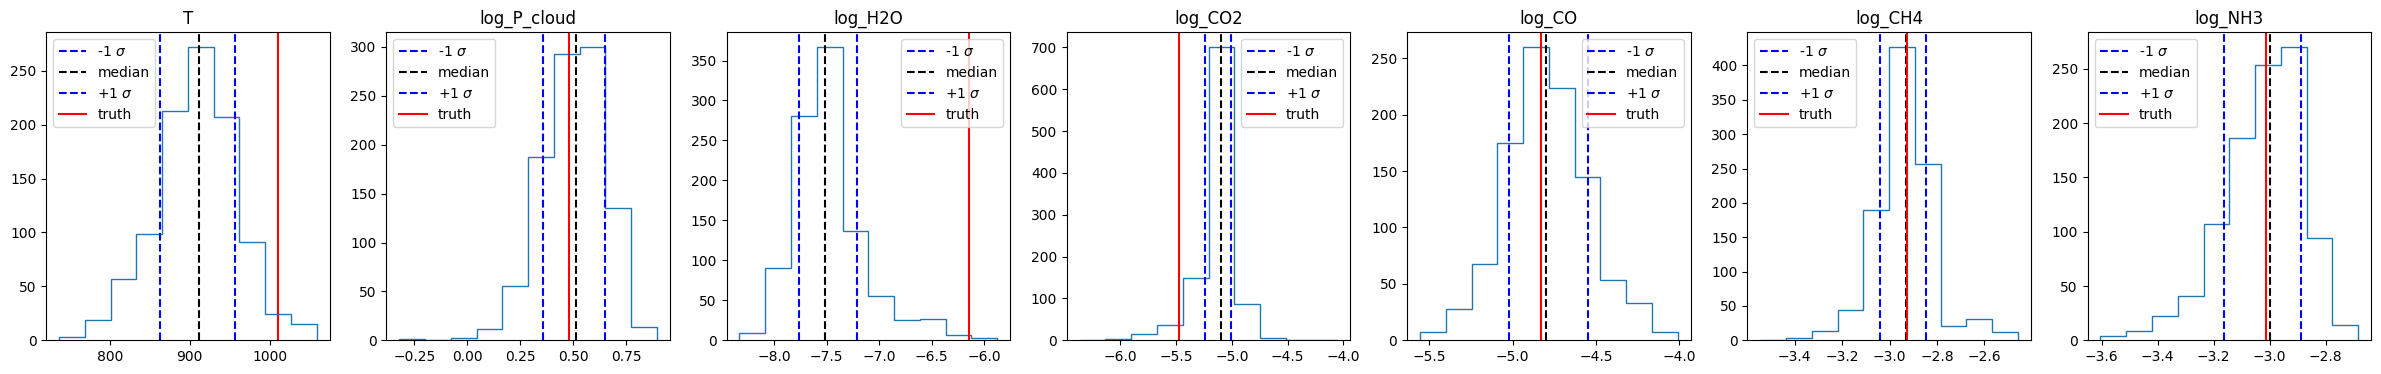

In [42]:
keys = ['T', 'log_P_cloud', 'log_H2O', 'log_CO2', 'log_CO', 'log_CH4', 'log_NH3']
fig, axs = plt.subplots(1, 7, figsize=(30,4))

for i in range(7):
#     if i < 4:
        axs[i].hist(prediction_dropout_ensemble[:,i],histtype='step',bins=10)
        axs[i].axvline(x=low_sigma[i],color='blue',ls='--',label='-1 $\sigma$')
        axs[i].axvline(x=pred_med[i],color='black',ls='--',label='median')
        axs[i].axvline(x=high_sigma[i],color='blue',ls='--',label='+1 $\sigma$')
        axs[i].axvline(x=planetC_params[3+i],color='red',label='truth')
        axs[i].set_title(keys[i])
        axs[i].legend()

### Nested Sampling Results

In [48]:
!pip install gdown

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [77]:
import gdown
planetA_ret = gdown.download(f"https://drive.google.com/uc?id=1xMKXiBVVjDDkUo1ZZGlBbg7TwmNtXp-z")
planetA_sam = np.loadtxt(planetA_ret)
planetA_sam = planetA_sam[:,:-1]
planetA_sam = np.delete(planetA_sam,6,1)

Downloading...
From: https://drive.google.com/uc?id=1xMKXiBVVjDDkUo1ZZGlBbg7TwmNtXp-z
To: /kaggle/working/post_equal_weights.dat
100%|██████████| 796k/796k [00:00<00:00, 97.9MB/s]


In [78]:
planetB_ret = gdown.download(f"https://drive.google.com/uc?id=1y93vTsV8O77eNVnHbUHNFMAscL3uZZui")
planetB_sam = np.loadtxt(planetB_ret)
planetB_sam = planetB_sam[:,:-1]
planetB_sam = np.delete(planetB_sam,6,1)

Downloading...
From: https://drive.google.com/uc?id=1y93vTsV8O77eNVnHbUHNFMAscL3uZZui
To: /kaggle/working/post_equal_weights.dat
100%|██████████| 703k/703k [00:00<00:00, 92.9MB/s]


In [79]:
planetC_ret = gdown.download(f"https://drive.google.com/uc?id=161Jkqnr5lds2QmD8z3WIjy2xlclMfzAu")
planetC_sam = np.loadtxt(planetC_ret)
planetC_sam = planetC_sam[:,:-1]
planetC_sam = np.delete(planetC_sam,6,1)

Downloading...
From: https://drive.google.com/uc?id=161Jkqnr5lds2QmD8z3WIjy2xlclMfzAu
To: /kaggle/working/post_equal_weights.dat
100%|██████████| 640k/640k [00:00<00:00, 116MB/s]


In [80]:
def change_sam(planet_ret_par):
    comp_par = np.zeros_like(planet_ret_par)
    comp_par[:,0] = planet_ret_par[:,5]
    comp_par[:,1] = planet_ret_par[:,6]
    comp_par[:,2] = planet_ret_par[:,0]
    comp_par[:,3] = planet_ret_par[:,1]
    comp_par[:,4] = planet_ret_par[:,2]
    comp_par[:,5] = planet_ret_par[:,3]
    comp_par[:,6] = planet_ret_par[:,4]
    return comp_par

In [81]:
planetA_sam = change_sam(planetA_sam)
planetB_sam = change_sam(planetB_sam)
planetC_sam = change_sam(planetC_sam)

In [85]:
def conf_int(samples):
    median = []
    low_sigma = []
    high_sigma = []
    for i in range(7):
        high_sigma.append(np.percentile(samples[:,i],84.1))
        median.append(np.percentile(samples[:,i],50))
        low_sigma.append(np.percentile(samples[:,i],15.9))

    low_sigma = np.array(low_sigma)
    median = np.array(median)
    high_sigma = np.array(high_sigma)
    return low_sigma, median, high_sigma

In [106]:
def plot_samples_his(samples, truths):
    median = []
    low_sigma = []
    high_sigma = []
    for i in range(7):
        high_sigma.append(np.percentile(samples[:,i],84.1))
        median.append(np.percentile(samples[:,i],50))
        low_sigma.append(np.percentile(samples[:,i],15.9))

    low_sigma = np.array(low_sigma)
    median = np.array(median)
    high_sigma = np.array(high_sigma)
    
    keys = ['T', 'log_P_cloud', 'log_H2O', 'log_CO2', 'log_CO', 'log_CH4', 'log_NH3']
    fig, axs = plt.subplots(1, 7, figsize=(30,4))

    for i in range(7):
            axs[i].hist(samples[:,i],histtype='step',bins=10)
            axs[i].axvline(x=low_sigma[i],color='blue',ls='--',label='-1 $\sigma$')
            axs[i].axvline(x=median[i],color='black',ls='--',label='median')
            axs[i].axvline(x=high_sigma[i],color='blue',ls='--',label='+1 $\sigma$')
            axs[i].axvline(x=truths[3+i],color='red',label='truth')
            axs[i].set_title(keys[i])
            axs[i].legend()
            
    median_val = np.round(median,3)
    return print("Median :",median_val)

Median : [ 2.254463e+03 -4.500000e-01 -6.501000e+00 -6.069000e+00 -2.720000e+00
 -3.861000e+00 -5.363000e+00]


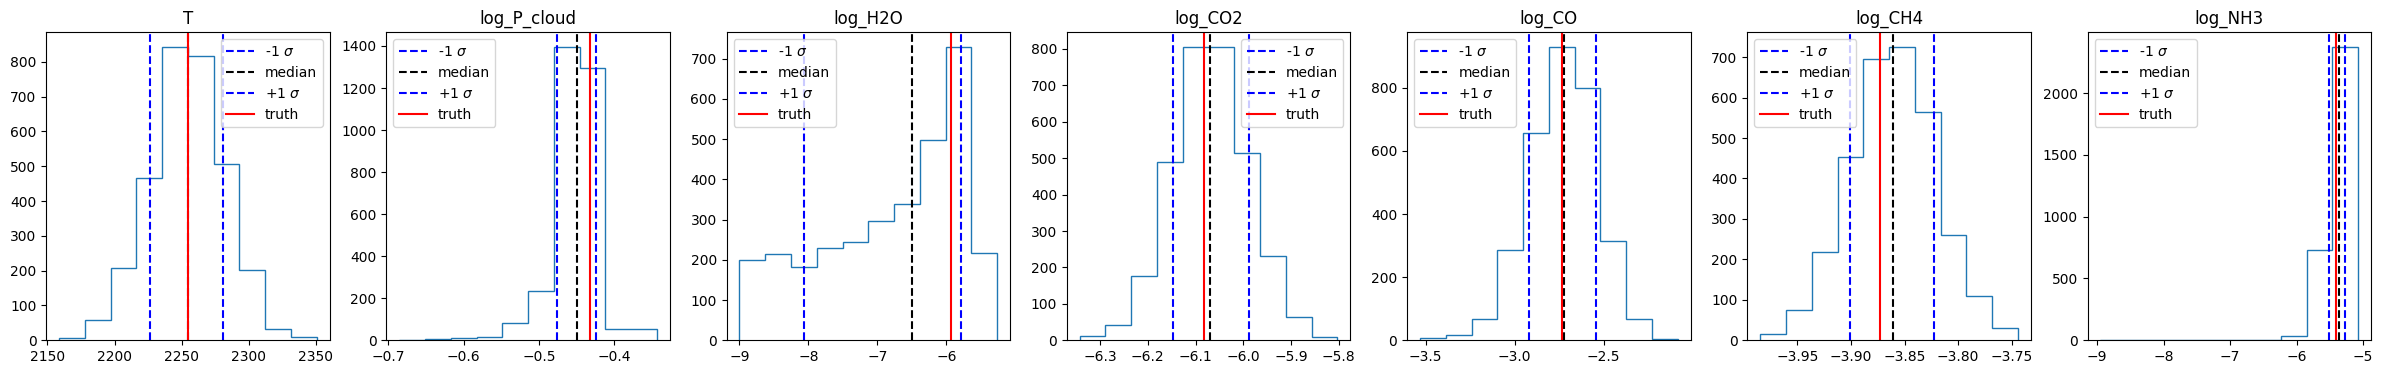

In [107]:

plot_samples_his(planetA_sam, planetA_params)

Median : [1494.389   -3.82    -2.026   -7.292   -6.606   -7.226   -4.439]


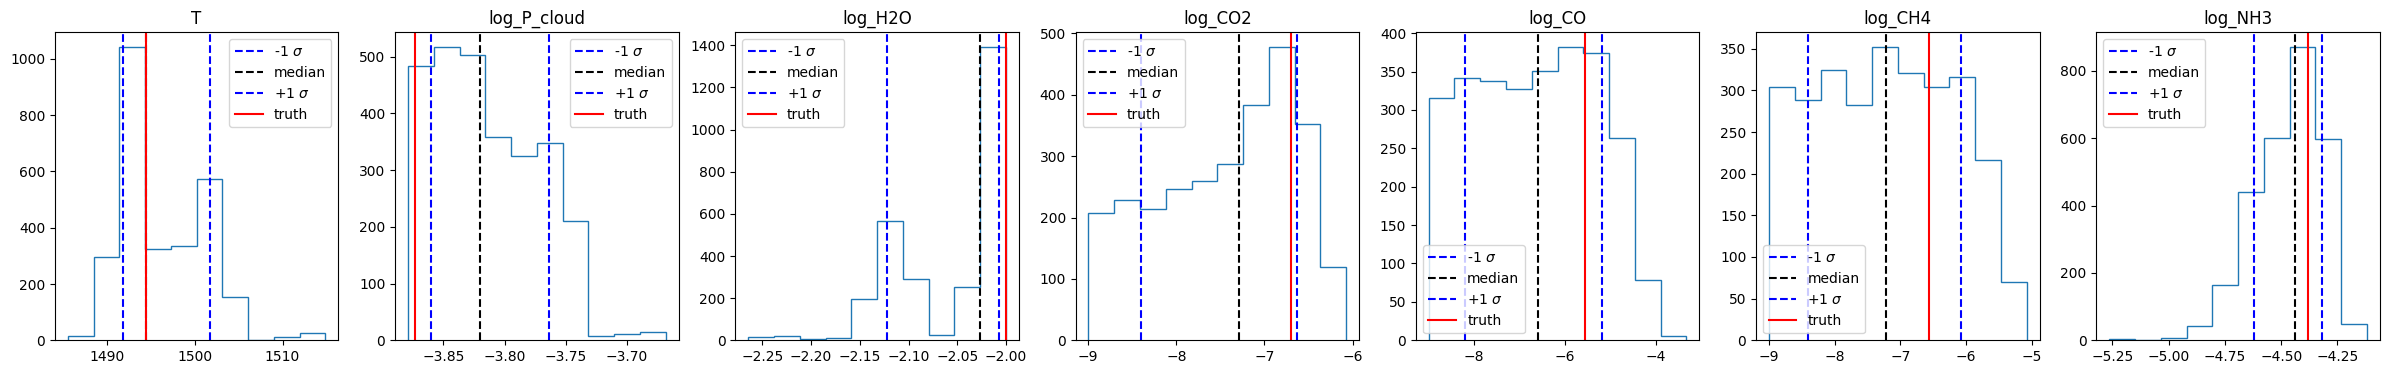

In [108]:
plot_samples_his(planetB_sam, planetB_params)

Median : [ 1.01145e+03  1.10000e-01 -6.63000e+00 -5.63900e+00 -5.80000e+00
 -2.93000e+00 -3.01100e+00]


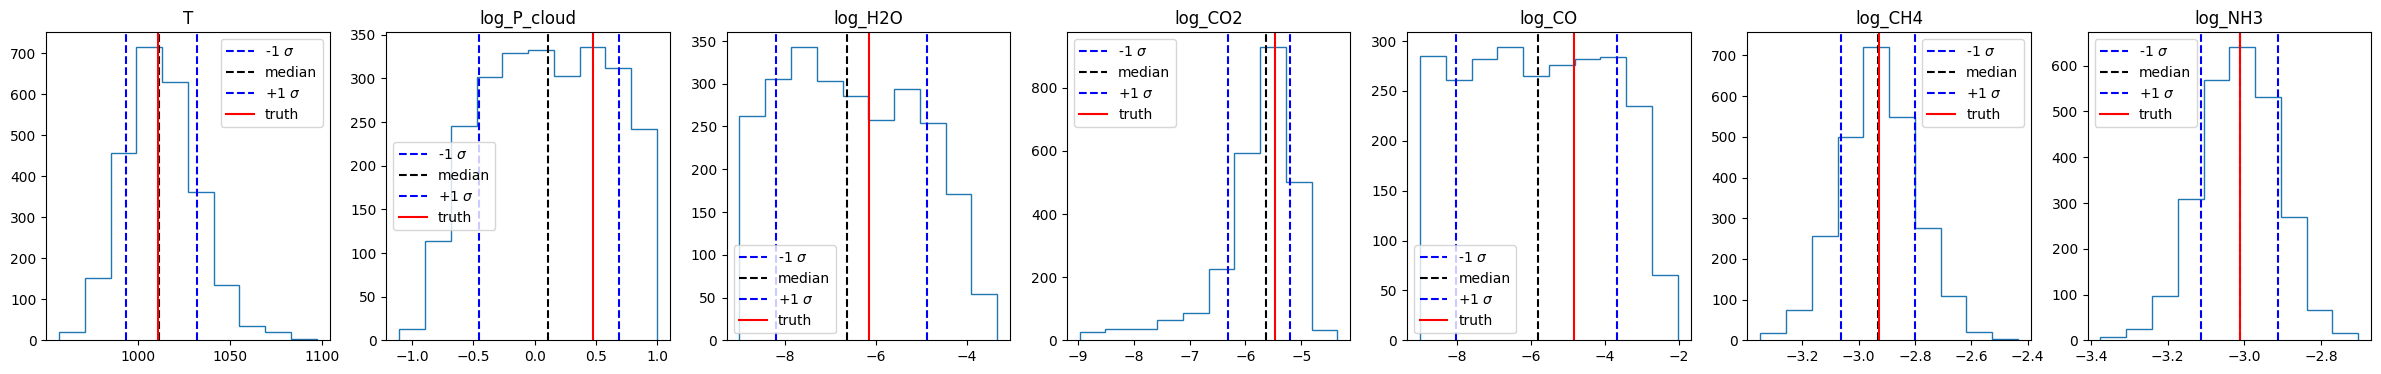

In [109]:
plot_samples_his(planetC_sam, planetC_params)

### Comapring NN and Nested

In [120]:
def nn_conf_int(model, planet, n_samples):    
    pred_err = []
    for i in range(n_samples):
        pred_err.append(model(planet,training = True).numpy().squeeze())
        
    prediction_dropout_ensemble = np.array(pred_err)
    prediction_dropout_ensemble = scaler.inverse_transform(prediction_dropout_ensemble)

    low_sigma = []
    median = []
    high_sigma = []
    for i in range(7):
        high_sigma.append(np.percentile(prediction_dropout_ensemble[:,i],84.1))
        median.append(np.percentile(prediction_dropout_ensemble[:,i],50))
        low_sigma.append(np.percentile(prediction_dropout_ensemble[:,i],15.9))

    low_sigma = np.array(low_sigma)
    median = np.array(median)
    high_sigma = np.array(high_sigma)
    
    return prediction_dropout_ensemble, low_sigma, median, high_sigma

In [ ]:
model = tr_cnn
planet = test_planets[2:3,:]
samples, low_sigma, median, high_sigma = nn_conf_int(model, planet, 1000)

In [169]:
def comp_hist_pl(samples, model, planet, truths): 
    
    print("Truth values:",truths[3:])
    
    low_sigma, median, high_sigma = conf_int(samples)
    print("Nested Median :",median)
    
    model = tr_cnn
    nn_samples, nn_low_sigma, nn_median, nn_high_sigma = nn_conf_int(model, planet, 1000)
    
    print("NN Median :",nn_median)
    
    keys = ['T', 'log_P_cloud', 'log_H2O', 'log_CO2', 'log_CO', 'log_CH4', 'log_NH3']
    fig, axs = plt.subplots(1, 7, figsize=(30,4))

    for i in range(7):
            axs[i].hist(samples[:,i],histtype='step',bins=10,label='Nested',stacked=True)
#             axs[i].axvline(x=low_sigma[i],color='blue',ls='--')
            axs[i].axvline(x=median[i],color='blue')
#             axs[i].axvline(x=high_sigma[i],color='blue',ls='--')
            
            axs[i].hist(nn_samples[:,i],histtype='step',bins=10,label='CNN')#,stacked=True)
#             axs[i].axvline(x=nn_low_sigma[i],color='orange',ls='--')
            axs[i].axvline(x=nn_median[i],color='black')
#             axs[i].axvline(x=nn_high_sigma[i],color='orange',ls='--')           

            axs[i].axvline(x=truths[3+i],color='red',label='truth')
            axs[i].set_title(keys[i])
            axs[i].legend()
    return 

Truth values: [ 2.25464503e+03 -4.32719523e-01 -5.92972315e+00 -6.08127349e+00
 -2.73321161e+00 -3.87322226e+00 -5.41191367e+00]
Nested Median : [ 2.25446309e+03 -4.50028058e-01 -6.50116366e+00 -6.06896606e+00
 -2.71987196e+00 -3.86057468e+00 -5.36253500e+00]
NN Median : [ 2.28942029e+03 -5.19057781e-01 -5.85650516e+00 -6.05517006e+00
 -2.97127759e+00 -3.81147218e+00 -5.37955189e+00]


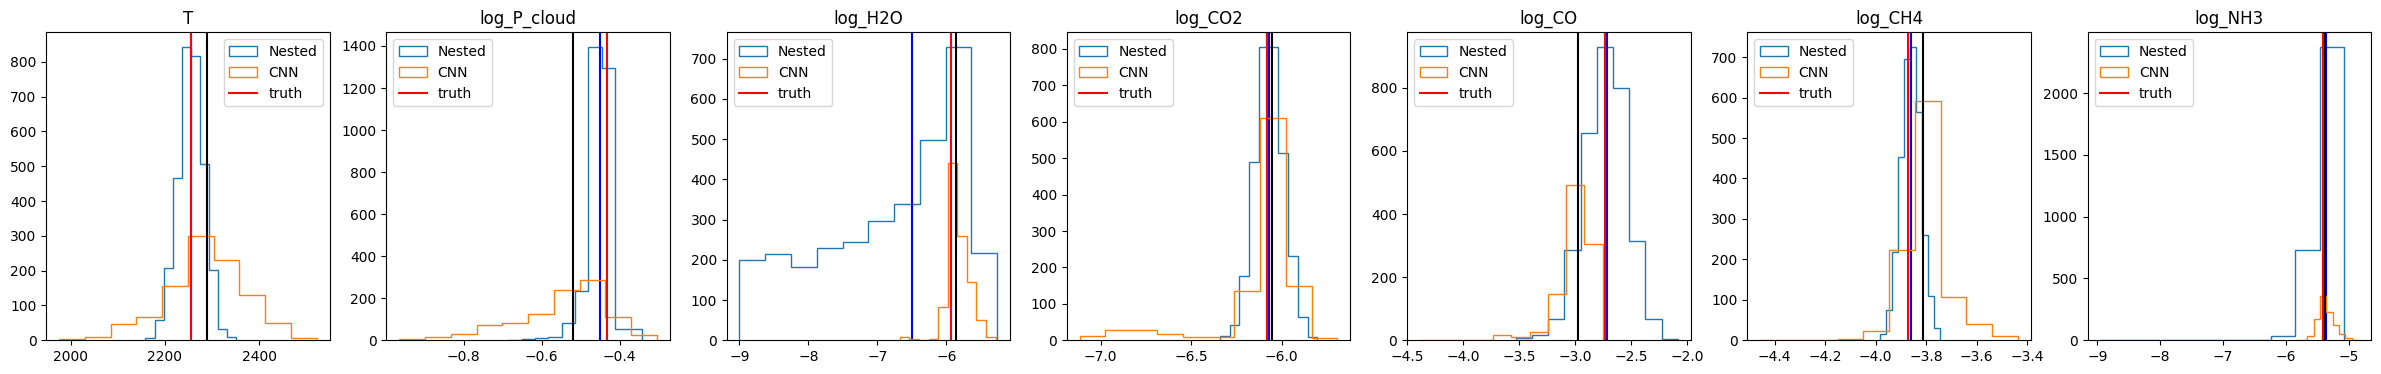

In [170]:
samples = planetA_sam
model = tr_cnn
planet = test_planets[0:1,:]
truths = planetA_params
comp_hist_pl(samples, model, planet, truths)

Truth values: [1494.42281919   -3.87293773   -2.00001683   -6.69599784   -5.56826031
   -6.57170199   -4.38080597]
Nested Median : [1494.38862462   -3.82034815   -2.02642711   -7.29214859   -6.60597066
   -7.22606051   -4.43942987]
NN Median : [1352.61938477   -3.54540491   -1.92911303   -6.83926249   -5.28433824
   -7.65218234   -4.88297415]


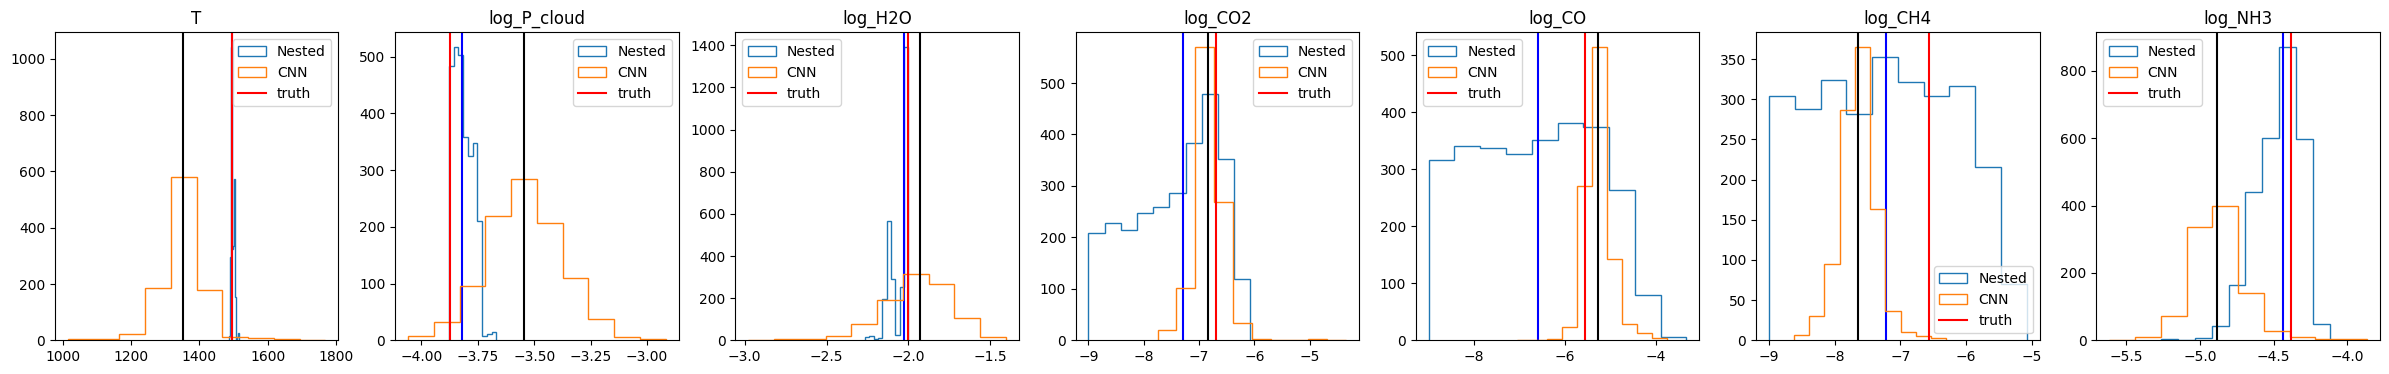

In [171]:
samples = planetB_sam
model = tr_cnn
planet = test_planets[1:2,:]
truths = planetB_params
comp_hist_pl(samples, model, planet, truths)

Truth values: [ 1.01071679e+03  4.78646000e-01 -6.14987707e+00 -5.47199553e+00
 -4.82762328e+00 -2.92644183e+00 -3.01204914e+00]
Nested Median : [ 1.01145014e+03  1.10440362e-01 -6.62965203e+00 -5.63850295e+00
 -5.79977538e+00 -2.93013676e+00 -3.01112968e+00]
NN Median : [ 9.12475006e+02  4.98032719e-01 -7.51164961e+00 -5.10842109e+00
 -4.79492712e+00 -2.92833829e+00 -3.00650525e+00]


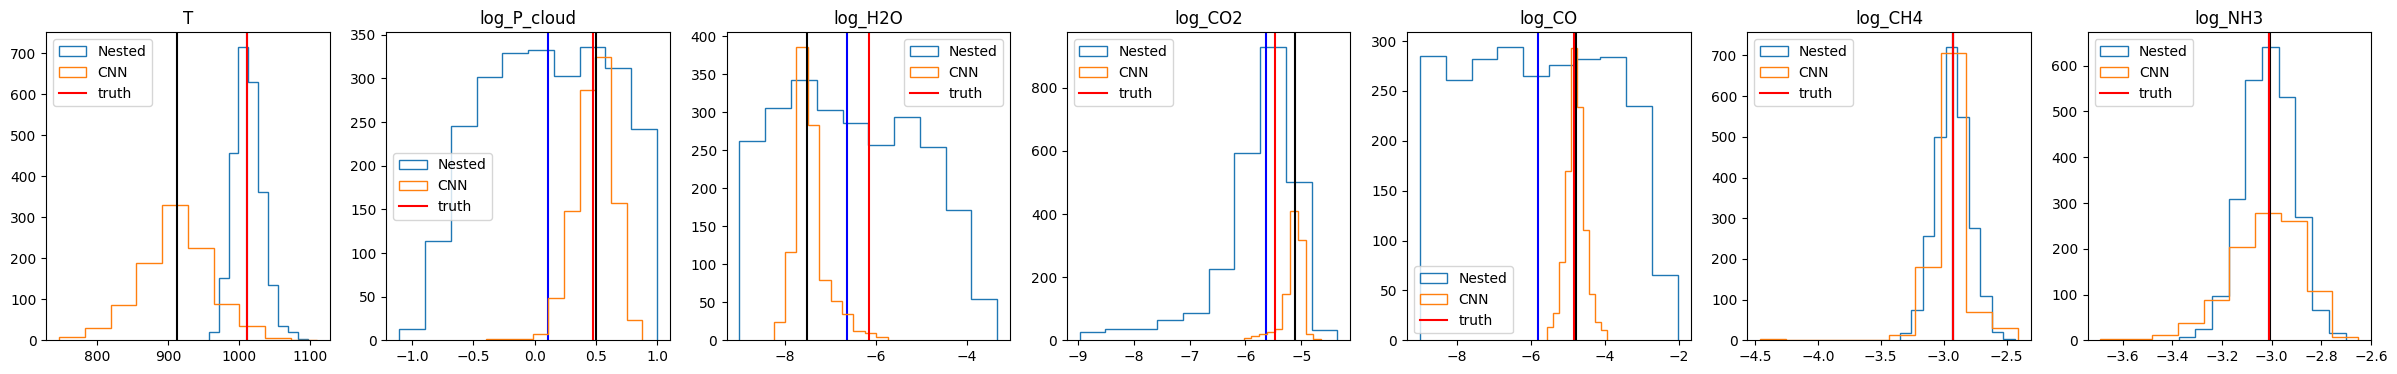

In [172]:
samples = planetC_sam
model = tr_cnn
planet = test_planets[2:3,:]
truths = planetC_params
comp_hist_pl(samples, model, planet, truths)